# Scaling up designs in synthetic biology using _pacti_

Research in synthetic biology has accelerated in the past decade due to its enormous promise in engineering biological systems for desired behavior. Applications range from biomedicine to engineered living materials and environmental remediation. From a design standpoint, mathematical models have been used to study the behavior of biological systems and analyze various properties. However, current experimental design approaches in synthetic biology are largely heuristics and trial-and-error based, hence, difficult to scale. To alleviate this, various modeling and analysis and logic gate design tools (like Cello) have been proposed but none have yet been used to successfully design large biological circuits. We believe that the _pacti_ framework holds the potential to address this issue of scale due to its generality in writing system specifications and in decoupling the modeling details of each component from their specification. 

![main_figure](main_figure.png)

To demonstrate the use of _pacti_ , we present a case study on the design of engineered biological circuits for altering and observing the dynamics of bacterial protein expression in soil and its effects on plant behavior. As shown in the Figure below, we consider a rhizosphere engineering system where engineered bacteria are introduced in to the soil near the plant roots to analyze the dynamics of protein expression in the plant. The input in this system design is a target gene of interest introduced in the soil through the bacteria. Through various biochemical processes, the goal is to measure the protein expression response of the plant in response to the target gene input. Without diving too deep into the biological details, we will summarize by saying that designing such a complex engineered biological system is not trivial due to a variety of factors. Some of these factors include the lack of information about the key biological mechanisms, absence of characterization data for system parts, and unknown effects of the soil context. With the use of _pacti_ , we envision speeding up the experimental design process in three ways: 

1. Characterized library of parts as assume-guarantee contracts: Using existing experimental data from literature, we present a library of sensors as assume-guarantee contracts that can be used to reason about specifications of diverse biological circuits. For the engineered bacteria case study, we use previously published data (for the Marionette cell lines) to construct a library of 14 sensors.
2. Speeding up the experimental design: Current experimental design approaches in synthetic biology are heavily reliant on screening experiments where all possible choices are explored experimentally to choose the one that works. This is not only time consuming and expensive but also does not scale beyond three or four independent choices. With the use of _pacti_ , we demonstrate how scientists may describe the desired top-level behavior as contracts and then computationally choose from a library of available parts to ensure that the components meet the top-level system specification. For the engineered bacteria case study, we find the specification of the sensors that meet the top-level criteria on fold-change of the circuit response.
3. Finding specifications of missing parts: In synthetic biology, it is common to have parts in the system for which no characterization data is available. Using quotient operation on contracts, we can find the constraints that this missing part must satisfy to meet the desired top-level criteria. For the bacterial case study, we find the missing contract of the dCas9-mediated repression mechanism (as shown in the B panel of the Figure above) for which characterization data is not available in the literature.

# Modeling the specifications to construct a library of parts

Using the experimental characterization data for the sensors in the _Marionette_ bacterial cell strain [1], we model the sensor behavior as assume-guarantee contracts. We observe that each sensor has three characteristic behaviors: (1) the off state, where the output of the sensor stays close to zero (the non-zero expression in this state is termed as "leaky response"), (2) the linear rate of output , where the sensor output responds linearly to the input (in log scale), (3) the saturation state, where the sensor output saturates to a maximum constant v

[1] Meyer, Adam J., et al. "Escherichia coli “Marionette” strains with 12 highly optimized small-molecule sensors." Nature chemical biology 15.2 (2019): 196-204.

In [1]:
# Load all required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sympy
from io import StringIO

from pacti.terms.polyhedra.loaders import read_contract, write_contract
from synbio_utils import display_sensor_contracts, remove_quantization_errors
import pacti.terms.polyhedra as gtp

In [2]:
# Read the data from the paper as a string
data = '''
Inducer,Plasmid,Regulator,Promoter,ymax (RPU),ymin (RPUx10-3),K (µM),n,Dynamic range,start,ymax Linear
DAPG,pAJM.847,PhlFAM,PPhlF,2.50,2.5,1.700,2.1,1000,0.03,2 
Cuma,pAJM.657,CymRAM,PCymRC,3.70,4.3,8.900,2.4,870,0.3,2
OC6,pAJM.474,LuxR,PLuxB,1.30,2.4,0.120,1.8,540,0.002,0.5
Van,pAJM.773,VanRAM,PVanCC,3.00,2.4,26.000,2.3,1200,1,1.8
IPTG,pAJM.336,LacIAM,PTac,3.30,4.8,140.000,1.8,690,2,1.5
aTc,pAJM.011,TetR,PTet*,2.40,4.9,0.013,3.8,500,0.0018,1
Ara,pAJM.677,AraCAM,PBAD,1.20,2.4,37.000,1.5,500,0.2,0.7
Cho,pAJM.683,BetIAM,PBetI,2.60,8.5,4100.00,2.7,310,300,0.9
Nar,pAJM.661,TtgRAM,PTtg,0.46,3.4,95.000,1.9,140,2,0.2
DHBA,pAJM.690,PcaUAM,P3B5B,1.60,4.5,370.000,1.8,360,9,1
Sal,pAJM.771,NahRAM,PSalTTC,2.80,4.7,43.000,1.8,600,0.9,1.3
OHC14,pAJM.1642,CinRAM,PCin,1.50,3.0,0.430,2.3,490,0.016,0.7
Acr,pAJM.884,AcuRAM,PAcu,3.10,37.0,130.000,2.5,83,10,1.7
Ery,pAJM.969,MphRAM,PMph,0.29,8.0,65.000,1.5,36,2,0.18
'''
df = pd.read_csv(StringIO(data))

df

,Inducer,Plasmid,Regulator,Promoter,ymax (RPU),ymin (RPUx10-3),K (µM),n,Dynamic range,start,ymax Linear
0,DAPG,pAJM.847,PhlFAM,PPhlF,2.50,2.5,1.700,2.1,1000,0.0300,2.00
1,Cuma,pAJM.657,CymRAM,PCymRC,3.70,4.3,8.900,2.4,870,0.3000,2.00
2,OC6,pAJM.474,LuxR,PLuxB,1.30,2.4,0.120,1.8,540,0.0020,0.50
3,Van,pAJM.773,VanRAM,PVanCC,3.00,2.4,26.000,2.3,1200,1.0000,1.80
4,IPTG,pAJM.336,LacIAM,PTac,3.30,4.8,140.000,1.8,690,2.0000,1.50
5,aTc,pAJM.011,TetR,PTet*,2.40,4.9,0.013,3.8,500,0.0018,1.00
6,Ara,pAJM.677,AraCAM,PBAD,1.20,2.4,37.000,1.5,500,0.2000,0.70
7,Cho,pAJM.683,BetIAM,PBetI,2.60,8.5,4100.000,2.7,310,300.0000,0.90
8,Nar,pAJM.661,TtgRAM,PTtg,0.46,3.4,95.000,1.9,140,2.0000,0.20
9,DHBA,pAJM.690,PcaUAM,P3B5B,1.60,4.5,370.000,1.8,360,9.0000,1.00


Create contracts for the sensor using this experimental data:

In [3]:
def create_sensor_contracts(sensor_input="AHL", output="FP", K=0.0, yleak=0.0, start = 0.0, ymax_lin = 0.0):
    """
    Creates the contracts for a Marionette sensing subsystem
    params:
        * input (str): The inducer input to the sensor
        * output (str): The output of the genetic construct. Inducer activates the 
                        production of this output
        * K (float): The value of the Hill activation parameter K
        * yleak (float): The minimum expression of output even in absence of inducer
        * start (float): The value of inducer at which the induction starts
        * ymax_lin (float): The maximum expression of output by the inducer
                            before saturating (the end of linear regime)
    """
    slope = (ymax_lin - yleak)/(K - start)
    intercept = yleak - slope*start
    contract_0 = {
            "_comment": "contract when sensor is OFF",
            "InputVars":[
                sensor_input
            ],
            "OutputVars":[
                output
            ],
            "assumptions":
            [
                {"coefficients":{sensor_input:1}, # "1*input <= start"
                "constant":start}
            ],
            "guarantees":[
                {"coefficients":{output:1},
                "constant":yleak}
            ]
        }
    contract_lin = {
            "_comment": "contract for sensor in linear regime",
            "InputVars":[
                sensor_input
            ],
            "OutputVars":[
                output
            ],
            "assumptions":
            [
                {"coefficients":{sensor_input:1},
                "constant":K},
                {"coefficients":{sensor_input:-1},
                "constant":-start}
            ],
            "guarantees":[
                {"coefficients":{output:-1, sensor_input:slope},
                "constant":intercept},
                {"coefficients":{output:1, sensor_input:-slope},
                "constant":-intercept}
            ]
        }
    contract_max = {
            "_comment": "contract for sensor in saturation",
            "InputVars":[
                sensor_input
            ],
            "OutputVars":[
                output
            ],
            "assumptions":
            [
                {"coefficients":{sensor_input:-1},
                "constant":-K}
            ],
            "guarantees":[
                {"coefficients":{output:-1},
                "constant":-ymax_lin}
            ]
        }
    return contract_0, contract_lin, contract_max

## Composition to find optimal sensor choices

To speed up the experimental screening, we use _pacti_ to choose a sensor from the library that meets the desired top-level behavior. Here, we have a tetracycline (aTc) sensor that expresses a dCas9 protein and the other sensor (the one we want to choose) that expresses the xRFP guide RNA. The xRFP guide RNA binds to dCas9 to repress the expression of red fluorescent protein (RFP), the output of the system. When either of the sensors are OFF, the output (RFP) is constitutively expressed (that is, output is ON). In this way, the system behavior is that of a NAND logic gate. We denote the contract for the tetracycline sensor as $C_{\text{atc}}$ and the contract for dCas9 repression mechanism as $C_{\text{dCas9}}$. For the top-level specification, we define the fold-change of the system as
$F = \frac{\text{RFP}_{\text{on}}}{\text{RFP}_{\text{off}}}.$

To choose the sensor that achieves the highest fold-change for the system, we compose the contract for each of the available 13 sensors in the library with the tetracycline contract and the dCas9 repression contract to obtain the top-level system contract. The composition operation in _pacti_ reports a design error for any sensor that is "unsatisfiable in the given context" to reject some of the choices while some other choices are rejected if they do not meet the set top-level system criteria.

In [4]:
# Create all sensor contracts:
sensor_names = [str(i) for i in df['Inducer']]
sensor_library = {}
sensor_library_params = {}
for sensor in sensor_names:
    sensor_params = {}
    yleak_s = df.loc[df["Inducer"] == sensor]["ymin (RPUx10-3)"].values[0]*1e-3
    s_start = df.loc[df["Inducer"] == sensor]["start"].values[0]
    s_K = df.loc[df["Inducer"] == sensor]["K (µM)"].values[0]
    ymax_s = df.loc[df["Inducer"] == sensor]["ymax Linear"].values[0]
    sensor_params = {"leak":yleak_s, "start":s_start, "K":s_K, "ymax":ymax_s}
    s_output = "dCas9"
    contract_s_0, contract_s_lin, contract_s_max = create_sensor_contracts(sensor_input=sensor, output="xRFP", 
                                                                           start=s_start, K=s_K,
                                                                           ymax_lin=ymax_s, yleak=yleak_s)
    sensor_library[sensor] = [contract_s_0, contract_s_lin, contract_s_max]
    sensor_library_params[sensor] = sensor_params

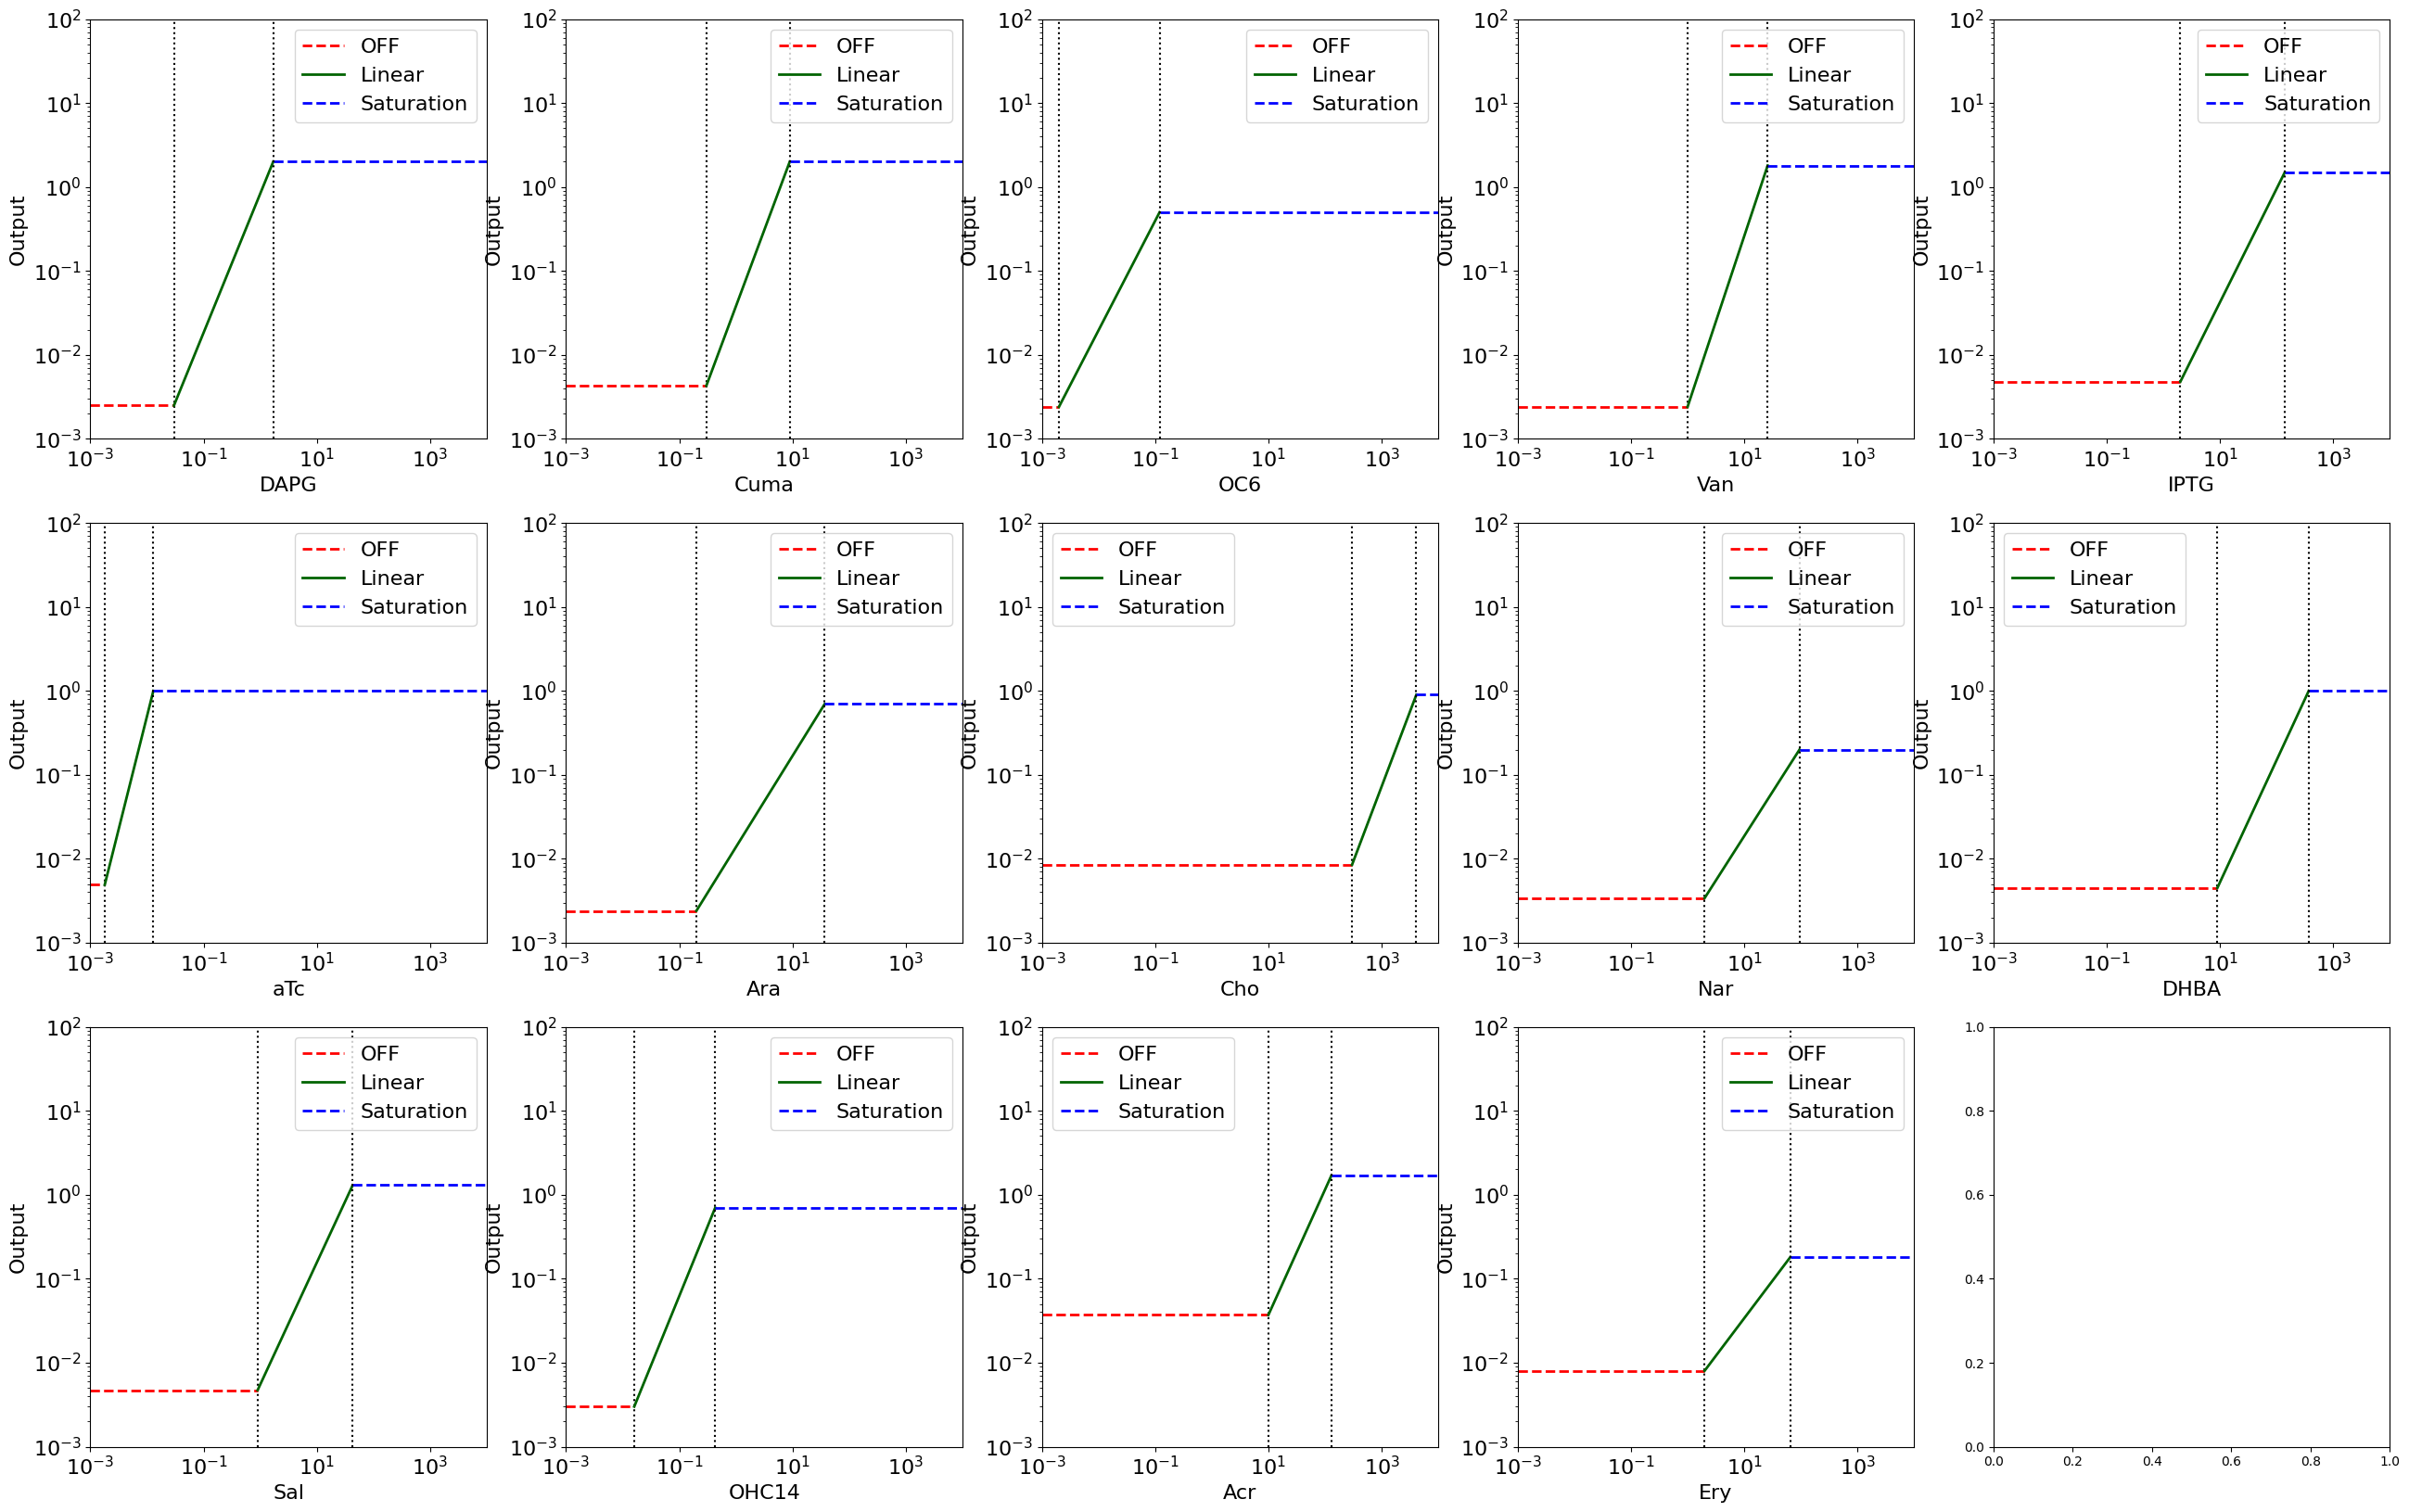

In [5]:
fig, all_ax = plt.subplots(nrows=3, ncols=5, figsize=(32,20))
index = 0
for sensor in sensor_names:
    ax = all_ax[index//5][index%5]
    index += 1
    yleak_s = df.loc[df["Inducer"] == sensor]["ymin (RPUx10-3)"].values[0]*1e-3
    s_start = df.loc[df["Inducer"] == sensor]["start"].values[0]
    s_K = df.loc[df["Inducer"] == sensor]["K (µM)"].values[0]
    ymax_s = df.loc[df["Inducer"] == sensor]["ymax Linear"].values[0]
    ax = display_sensor_contracts(sensor_input=sensor, output="", leak=yleak_s,
                                  start=s_start, K=s_K, ymax_lin=ymax_s,
                                  xlim_min=10**-3, xlim_max=10**4, ylim_min=10**-3, ylim_max=10**2,
                                  ax=ax, show=False)
    ax.set_xlabel(sensor, fontsize=16)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    ax.set_ylabel("Output", fontsize=16)
    ax.legend(fontsize=16)
# plt.savefig('all_sensors.svg')
plt.show()

Write the contract for the dCas9 repression mechanism

In [6]:
dCas9_contract_off = {
            "_comment": "xRFP:OFF, dCas9:OFF, RFP:ON",
            "InputVars":[
                "xRFP", "dCas9"
            ],
            "OutputVars":[
                "RFP"
            ],
            "assumptions":
            [
                {"coefficients":{"xRFP":1},
                "constant":0.2}, # xRFP < 0.2
                {"coefficients":{"dCas9":1},
                "constant":0.1}, # dCas9 < 0.1
            ],
            "guarantees":[
                {"coefficients":{"RFP":-1},
                 "constant":-10}, # RFP >= 10
            ]
        }

dCas9_contract_on = {
            "_comment": "The dCas9 repression: xRFP:ON, dCas9:ON, RFP:OFF",
            "InputVars":[
                "xRFP", "dCas9"
            ],
            "OutputVars":[
                "RFP"
            ],
            "assumptions":
            [
                {"coefficients":{"xRFP":-1},
                "constant":-0.3}, # xRFP > 0.3
                {"coefficients":{"xRFP":1},
                "constant":1}, # xRFP < 1
                {"coefficients":{"dCas9":-1},
                "constant":-0.1}, # dCas9 > 0.1
                {"coefficients":{"dCas9":1},
                "constant":0.8}, # dCas9 < 0.8
            ],
            "guarantees":[
                {"coefficients":{"RFP":1, "xRFP":2, "dCas9":0.1},
                 "constant":5}, # RFP < 5 - 2xRFP - 0.1dCas9
            ]
        }

In [7]:
c_dcas9_off, c_dcas9_on = read_contract([dCas9_contract_off, dCas9_contract_on])

In [8]:
input2 = "aTc"
sensor_ok = {}
fold_change = {}
desired_fold_change = 4
for sensor in sensor_library:
    in1_params = sensor_library_params[sensor]
    in2 = "aTc"
    in2_params= sensor_library_params[in2]
    c_atc_off, c_atc_on, c_atc_sat = create_sensor_contracts(sensor_input="aTc", output="dCas9", 
                                                             start=in2_params["start"],
                                                             K=in2_params["K"],
                                                             ymax_lin=in2_params["ymax"],
                                                             yleak=in2_params["leak"])
    if sensor != "aTc":  
        try:
            # OFF condition
            c_sensor1 = read_contract(sensor_library[sensor][0])
            c_sensor2 = read_contract(c_atc_off)
            sensor_comp = c_sensor2.compose(c_sensor1)
            top_level_off = sensor_comp.compose(c_dcas9_off)
            top_level_off = remove_quantization_errors(top_level_off)
            sym_expr = gtp.PolyhedralTerm.to_symbolic(top_level_off.g.terms[0])
            rfp_vals_on = {}
            updated_sym = sym_expr.subs(sensor, 0.9*in1_params["start"])
            updated_sym = updated_sym.subs(in2, 0.9*in2_params["start"])
            subs_val = sympy.solve(updated_sym, "RFP")
            rfp_vals_on[in1_params["start"], in2_params["start"]] = subs_val[0]
            # ON condition
            c_sensor1 = read_contract(sensor_library[sensor][1])
            c_sensor2 = read_contract(c_atc_on)
            sensor_comp = c_sensor2.compose(c_sensor1)
            top_level_on = sensor_comp.compose(c_dcas9_on)
            top_level_on = remove_quantization_errors(top_level_on)
            sym_expr = gtp.PolyhedralTerm.to_symbolic(top_level_on.g.terms[0])
            rfp_vals_off = {}
            updated_sym = sym_expr.subs(sensor, 0.9*in1_params["K"])
            updated_sym = updated_sym.subs(in2, 0.9*in2_params["K"])
            subs_val = sympy.solve(updated_sym, "RFP")
            rfp_vals_off[in1_params["K"], in2_params["K"]] = subs_val[0]
            fold_change[sensor] = list(rfp_vals_on.values())[0]/list(rfp_vals_off.values())[0]
            if fold_change[sensor] > desired_fold_change:
                sensor_ok[sensor] = True
            else:
                sensor_ok[sensor] = False
        except ValueError as e:
            if "unsatisfiable in context" in str(e):
                sensor_ok[sensor] = False
            else:
                print(str(e))


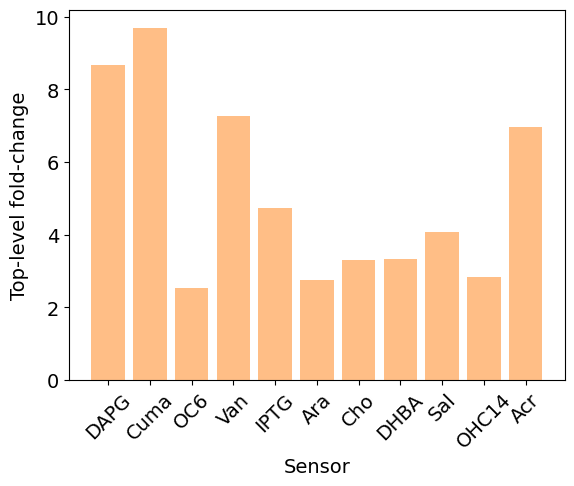

In [9]:
fig, ax = plt.subplots()
ax.bar(fold_change.keys(), fold_change.values(), color='C1', alpha=0.5)

ax.set_xlabel("Sensor", fontsize=14)
ax.set_ylabel("Top-level fold-change", fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Note that not all sensors were compatible. Some of the sensor choices led to errors in design automatically caught by _pacti_ :

In [10]:
fold_change

{'DAPG': 8.66785005774809,
 'Cuma': 9.68674395539190,
 'OC6': 2.52677363203287,
 'Van': 7.26517302130202,
 'IPTG': 4.72491416737617,
 'Ara': 2.76605435260938,
 'Cho': 3.30535361336978,
 'DHBA': 3.32963257502971,
 'Sal': 4.07634004092162,
 'OHC14': 2.83319542816097,
 'Acr': 6.97093280769728}

In [11]:
sensor_ok

{'DAPG': True,
 'Cuma': True,
 'OC6': False,
 'Van': True,
 'IPTG': True,
 'Ara': False,
 'Cho': False,
 'Nar': False,
 'DHBA': False,
 'Sal': True,
 'OHC14': False,
 'Acr': True,
 'Ery': False}

# Finding specifications of missing parts

For the NAND gate described above, if we write a desired top-level contract $C_{\text{sys}}$ and assume that both sensors have been chosen (here we choose Sal and aTc) so that we have the contracts for both sensors. Then, we may use quotient operation in _pacti_ to find the ideal specifications of the dCas9 mechanism. This can guide the design of the repression mechanism.


### Contract for Sal sensor:

In [12]:
yleak_sal = df.loc[df["Inducer"] == "Sal"]["ymin (RPUx10-3)"].values[0]*1e-3
sal_start = df.loc[df["Inducer"] == "Sal"]["start"].values[0]
sal_K = df.loc[df["Inducer"] == "Sal"]["K (µM)"].values[0]
ymax_sal = df.loc[df["Inducer"] == "Sal"]["ymax Linear"].values[0]

sal_output = "xRFP"
contract_sal_min, contract_sal_lin, contract_sal_max = create_sensor_contracts(sensor_input="Sal", output=sal_output, 
                                                                               start=sal_start, K=sal_K,
                                                                               ymax_lin=ymax_sal, yleak=yleak_sal)

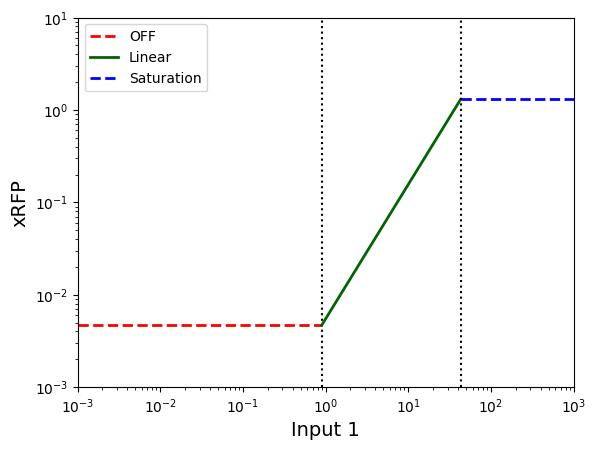

In [13]:
display_sensor_contracts(sensor_input="Input 1", output="xRFP", leak=yleak_sal,
                         start=sal_start, K=sal_K, ymax_lin=ymax_sal,
                         xlim_min=10**-3, xlim_max=10**3, ylim_min=10**-3, ylim_max=10**1);

### Contracts for aTc sensor

In [14]:
yleak_atc = df.loc[df["Inducer"] == "aTc"]["ymin (RPUx10-3)"].values[0]*1e-3
atc_start = df.loc[df["Inducer"] == "aTc"]["start"].values[0]
atc_K = df.loc[df["Inducer"] == "aTc"]["K (µM)"].values[0]
ymax_atc =df.loc[df["Inducer"] == "aTc"]["ymax Linear"].values[0]
atc_output = "dCas9"
contract_atc_min, contract_atc_lin, contract_atc_max = create_sensor_contracts(sensor_input="aTc", output=atc_output, 
                                                                               start=atc_start, K=atc_K,
                                                                               ymax_lin=ymax_atc, yleak=yleak_atc)

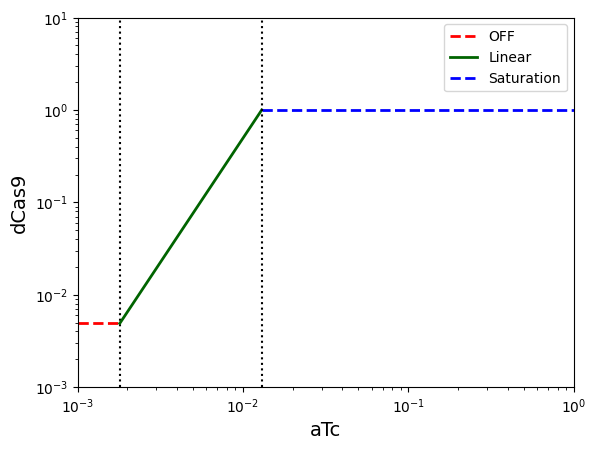

In [15]:
display_sensor_contracts(sensor_input="aTc", output="dCas9", leak=yleak_atc,
                         start=atc_start, K=atc_K, ymax_lin=ymax_atc,
                         xlim_min=10**-3, xlim_max=10**0, ylim_min=10**-3, ylim_max=10**1);

### Top-level system contract

In [16]:
leak_RFP = np.max([yleak_atc, yleak_sal])
max_RFP = np.max([ymax_atc, ymax_sal])
def create_top_level_contracts(input1 = "u1", input2 = "u2", output="y", 
                               input1_params = None, input2_params = None, output_params = None):
    """
    Creates the top level system contracts
    """
    u1_start = input1_params["start"]
    u1_K = input1_params["K"]

    u2_start = input2_params["start"]
    u2_K = input2_params["K"]

    y_max = output_params["max"]
    y_leak = output_params["leak"]
    all_contracts = []
    contract_top_level_on1 = {
            "_comment": "u1:OFF, u2:OFF, y:ON",
            "InputVars":[
                input1, input2
            ],
            "OutputVars":[
                output
            ],
            "assumptions":
            [
                {"coefficients":{input1:1},
                "constant":u1_start - u1_start*0.01},
                {"coefficients":{input1:1},
                "constant":u2_start - u2_start*0.01}
            ],
            "guarantees":[
                {"coefficients":{output:-1},
                "constant":-y_max},
            ]
        }
    all_contracts.append(contract_top_level_on1)
    contract_top_level_on2 = {
            "_comment": "u1:ON, u2:OFF, y:ON",
            "InputVars":[
                input1, input2
            ],
            "OutputVars":[
                output
            ],
            "assumptions":
            [
                {"coefficients":{input1:-1},
                "constant":-(u1_start + u2_start*0.01)},
                {"coefficients":{input1:1},
                "constant":u1_K - u1_K*0.01},
                {"coefficients":{input2:1},
                "constant":u2_start - u2_start*0.01}
            ],
            "guarantees":[
                {"coefficients":{output:-1},
                "constant":-y_max},
            ]
        }
    all_contracts.append(contract_top_level_on2)
    contract_top_level_on3 = {
            "_comment": "u1:OFF, u2:ON, y:ON",
            "InputVars":[
                input1, input2
            ],
            "OutputVars":[
                output
            ],
            "assumptions":
            [
                {"coefficients":{input1:1},
                "constant":u1_start - u1_start*0.01},
                {"coefficients":{input2:-1},
                "constant":-(u2_start + u2_start*0.01)},
                {"coefficients":{input2:1},
                "constant":u2_K - u2_K*0.01},
            ],
            "guarantees":[
                {"coefficients":{output:-1},
                "constant":-y_max},
            ]
        }
    all_contracts.append(contract_top_level_on3)
    contract_top_level_off = {
            "_comment": "u1:ON, u2:ON, y:OFF",
            "InputVars":[
                input1, input2
            ],
            "OutputVars":[
                output
            ],
            "assumptions":
            [
                {"coefficients":{input1:-1},
                "constant":-(u1_start + u1_start*0.01)},
                {"coefficients":{input1:1},
                "constant":u1_K - u1_K*0.01},
                {"coefficients":{input2:-1},
                "constant":-(u2_start + u2_start*0.01)},
                {"coefficients":{input2:1},
                "constant":u2_K - u2_K*0.01},
            ],
            "guarantees":[
                {"coefficients":{output:1},
                "constant":y_leak},   
            ]
        }
    all_contracts.append(contract_top_level_off)
    return all_contracts

In [17]:
sal_params = {"start":sal_start, "K":sal_K}
atc_params = {"start":atc_start, "K":atc_K}
RFP_params = {"max":max_RFP, "leak":leak_RFP}
ctop_on1, ctop_on2, ctop_on3, ctop_off = create_top_level_contracts(input1 = "Sal",
                                                                    input2 = "aTc",
                                                                    output = "RFP",
                                                                    input1_params=sal_params,
                                                                    input2_params=atc_params,
                                                                    output_params=RFP_params)

In [18]:
csal_OFF, csal_ON, csal_SAT = read_contract([contract_sal_min, contract_sal_lin, contract_sal_max])
catc_OFF, catc_ON, catc_SAT = read_contract([contract_atc_min, contract_atc_lin, contract_atc_max])
ctop_off_off, ctop_on_off, ctop_off_on, ctop_on_on = read_contract([ctop_on1, ctop_on2, ctop_on3, ctop_off])

### Print the contracts

In [19]:
print(catc_ON)

InVars: [<Var aTc>]
OutVars:[<Var dCas9>]
A: 1*aTc <= 0.013, -1*aTc <= -0.0018
G: 88.84821428571429*aTc + -1.0*dCas9 <= -0.15502678571428574, -88.84821428571429*aTc + 1.0*dCas9 <= 0.15502678571428574


In [20]:
print(csal_ON)

InVars: [<Var Sal>]
OutVars:[<Var xRFP>]
A: 1*Sal <= 43.0, -1*Sal <= -0.9
G: 0.03076722090261283*Sal + -1.0*xRFP <= -0.0229904988123516, -0.03076722090261283*Sal + 1.0*xRFP <= 0.02299049881235149


### Available composition 
(in the NAND gate ON condition => output is OFF)

In [21]:
print(csal_ON.compose(catc_ON))

InVars: [<Var Sal>, <Var aTc>]
OutVars:[<Var xRFP>, <Var dCas9>]
A: 1*Sal <= 43.0, -1*Sal <= -0.9, 1*aTc <= 0.0129999999999999, -1*aTc <= -0.0018000000000000238
G: 0.03076722090261283*Sal + -1.0*xRFP <= -0.0229904988123516, -0.03076722090261283*Sal + 1.0*xRFP <= 0.02299049881235149, 88.84821428571429*aTc + -1.0*dCas9 <= -0.15502678571428574, -88.84821428571429*aTc + 1.0*dCas9 <= 0.15502678571428574


In [22]:
print(ctop_on_on)

InVars: [<Var Sal>, <Var aTc>]
OutVars:[<Var RFP>]
A: -1*Sal <= -0.909, 1*Sal <= 42.57, -1*aTc <= -0.001818, 1*aTc <= 0.01287
G: 1*RFP <= 0.004899999999999904


#### Take the quotient of the top-level contract in the ON condition from the available composition

In [23]:
csal_atc = csal_ON.compose(catc_ON)
dCas_repression_lin = ctop_on_on.quotient(csal_atc)

In [24]:
print(dCas_repression_lin)

InVars: [<Var xRFP>, <Var dCas9>]
OutVars:[<Var RFP>]
A: -1.0*xRFP <= -0.0509579026128266, 1.0*xRFP <= 1.33275109263658, -1.0*dCas9 <= -0.316552839285713, 1.0*dCas9 <= 1.29850330357142
G: 1*RFP <= 0.004899999999999904


#### Find contract for the missing subsystem for other conditions of the NAND gate circuit:

In [25]:
print(csal_OFF)

InVars: [<Var Sal>]
OutVars:[<Var xRFP>]
A: 1*Sal <= 0.9
G: 1*xRFP <= 0.0046999999999999265


In [26]:
print(catc_ON)

InVars: [<Var aTc>]
OutVars:[<Var dCas9>]
A: 1*aTc <= 0.013, -1*aTc <= -0.0018
G: 88.84821428571429*aTc + -1.0*dCas9 <= -0.15502678571428574, -88.84821428571429*aTc + 1.0*dCas9 <= 0.15502678571428574


In [27]:
print(csal_OFF.compose(catc_ON))

InVars: [<Var Sal>, <Var aTc>]
OutVars:[<Var xRFP>, <Var dCas9>]
A: 1*Sal <= 0.8999999999999999, 1*aTc <= 0.0129999999999999, -1*aTc <= -0.0018000000000000238
G: 1.0*xRFP <= 0.0046999999999999265, 88.84821428571429*aTc + -1.0*dCas9 <= -0.15502678571428574, -88.84821428571429*aTc + 1.0*dCas9 <= 0.15502678571428574


In [28]:
print(ctop_off_on)

InVars: [<Var Sal>, <Var aTc>]
OutVars:[<Var RFP>]
A: 1*Sal <= 0.891, -1*aTc <= -0.001818, 1*aTc <= 0.01287
G: -1*RFP <= -1.3


In [29]:
csal_atc = csal_OFF.compose(catc_ON)
dCas_repression_off_on = ctop_off_on.quotient(csal_atc)

In [30]:
print(dCas_repression_off_on)

InVars: [<Var xRFP>, <Var dCas9>]
OutVars:[<Var RFP>]
A: 1.0*xRFP <= 0.0046999999999999265, -1.0*dCas9 <= -0.316552839285713, 1.0*dCas9 <= 1.29850330357142
G: -1*RFP <= -1.3


Write results to a JSON file:

In [31]:
system_json_contracts = write_contract([dCas_repression_lin, dCas_repression_off_on], "dCas9_repression.json")